In [1]:
import os
import requests, zipfile, io
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.feature_selection import RFE
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold


%matplotlib inline
crs = 'epsg:4326'

# Internet Speed Data

## Get the data

In [2]:
def get_internet_data():
    '''
    Downloads data internet speed data from S3 bucket
    '''
    if not os.path.isdir('./2020-04-01_performance_fixed_tiles'):
        r = requests.get("https://ookla-open-data.s3-us-west-2.amazonaws.com/shapefiles/performance/type%3Dfixed/year%3D2020/quarter%3D2/2020-04-01_performance_fixed_tiles.zip")
        zf = zipfile.ZipFile(io.BytesIO(r.content))
        zf.extractall("2020-04-01_performance_fixed_tiles")
    else:
        print('file already in directory')
    
    df = gpd.read_file("2020-04-01_performance_fixed_tiles/gps_fixed_tiles.shp")
    return df

speed = get_internet_data()
speed.head()

file already in directory


,quadkey,avg_d_kbps,avg_u_kbps,avg_lat_ms,tests,devices,geometry
0,1321222233020202,144116,125751,3,7330,1324,"POLYGON ((113.55469 22.16197, 113.56018 22.161..."
1,1230231303303002,89763,52939,42,726,137,"POLYGON ((55.41504 25.27947, 55.42053 25.27947..."
2,0313131210131030,62657,15479,19,271,40,"POLYGON ((-1.79077 51.55658, -1.78528 51.55658..."
3,0213330110110321,98061,11842,19,2,1,"POLYGON ((-93.22449 45.06576, -93.21899 45.065..."
4,3100130032202231,15167,7287,8,674,122,"POLYGON ((107.59460 -6.91552, 107.60010 -6.915..."


In [5]:
def get_counties_shape():
    '''
    Downloads counties shapedile from U.S Census Bureau
    '''
    county_url = "https://www2.census.gov/geo/tiger/TIGER2019/COUNTY/tl_2019_us_county.zip" 
    counties = gpd.read_file(county_url).to_crs(4326)
    counties = counties.drop(columns=['COUNTYFP','COUNTYNS', 'LSAD','CLASSFP', 'MTFCC', 'CSAFP', 'CBSAFP', 'METDIVFP', 'FUNCSTAT', 
                'ALAND','AWATER'])
    return counties
counties = get_counties_shape()
counties.head()

,STATEFP,GEOID,NAME,NAMELSAD,INTPTLAT,INTPTLON,geometry
0,31,31039,Cuming,Cuming County,+41.9158651,-096.7885168,"POLYGON ((-97.01952 42.00410, -97.01952 42.004..."
1,53,53069,Wahkiakum,Wahkiakum County,+46.2946377,-123.4244583,"POLYGON ((-123.43640 46.23819, -123.44759 46.2..."
2,35,35011,De Baca,De Baca County,+34.3592729,-104.3686961,"POLYGON ((-104.56739 33.99757, -104.56772 33.9..."
3,31,31109,Lancaster,Lancaster County,+40.7835474,-096.6886584,"POLYGON ((-96.91075 40.78494, -96.91075 40.790..."
4,31,31129,Nuckolls,Nuckolls County,+40.1764918,-098.0468422,"POLYGON ((-98.27367 40.08940, -98.27367 40.089..."


In [6]:
def merge_speed_counties(speed_data, counties_data):
    #Merge Speed data with county boundaries
    county_speed = gpd.sjoin(counties_data, speed_data, how="left", op='intersects')
    # convert to Mbps for easier reading
    county_speed['avg_d_mbps'] = county_speed['avg_d_kbps'] / 1000
    county_speed['avg_u_mbps'] = county_speed['avg_u_kbps'] / 1000
    return county_speed
df = merge_speed_counties(speed, counties)

## Aggregate by county

In [7]:
#Aggregate the download speed by the number of test on a county
df_all = (df.groupby(["GEOID", "NAMELSAD"]).apply(
        lambda x: pd.Series(
            {"avg_d_mbps_wt": np.average(x["avg_d_mbps"], weights=x["tests"])})).reset_index()
    .merge(
        df.groupby(["GEOID", "NAMELSAD"]).agg(tests=("tests", "sum")).reset_index(),
        on=["GEOID", "NAMELSAD"]))

df_all.head()

,GEOID,NAMELSAD,avg_d_mbps_wt,tests
0,01001,Autauga County,141.184155,5005.0
1,01003,Baldwin County,102.417593,25047.0
2,01005,Barbour County,65.590938,691.0
3,01007,Bibb County,39.640721,714.0
4,01009,Blount County,62.067675,4748.0


In [53]:
county_speed = df_all.loc[df_all["tests"] >= 50, :]
county_speed.count()

labels = ["0 to 50 Mbps", "50 to 100 Mbps", "More than 100 Mbps"]

county_speed['group'] = pd.cut(
    county_speed.avg_d_mbps_wt, 
    (0, 50, 100, 530), 
    right=False, 
    labels = labels)
county_speed.head(5)

label2 = [1, 2, 3]

county_speed['group_num'] = pd.cut(
    county_speed.avg_d_mbps_wt, 
    (0, 50, 100, 530), 
    right=False, 
    labels = label2)
county_speed.head(5)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,GEOID,NAMELSAD,avg_d_mbps_wt,tests,group,group_num
0,01001,Autauga County,141.184155,5005.0,More than 100 Mbps,3
1,01003,Baldwin County,102.417593,25047.0,More than 100 Mbps,3
2,01005,Barbour County,65.590938,691.0,50 to 100 Mbps,2
3,01007,Bibb County,39.640721,714.0,0 to 50 Mbps,1
4,01009,Blount County,62.067675,4748.0,50 to 100 Mbps,2


In [54]:
county_data = counties[['GEOID', 'geometry', 'NAME', 'STATEFP']].merge(county_speed, on='GEOID', how='left').to_crs(26916)
#We will work just with USA continental
county_data = county_data[(county_data.STATEFP != '02') & (county_data.STATEFP  != '15')
                              & (county_data.STATEFP  != '69') & (county_data.STATEFP  != '78')
                             & (county_data.STATEFP  != '66') & (county_data.STATEFP  != '60') 
                          & (county_data.STATEFP  != '72')]
county_data['STATEFP'].nunique()

49

(-2969748.062021963, 2331634.8865646683, 2537930.7192537906, 6269757.003164073)

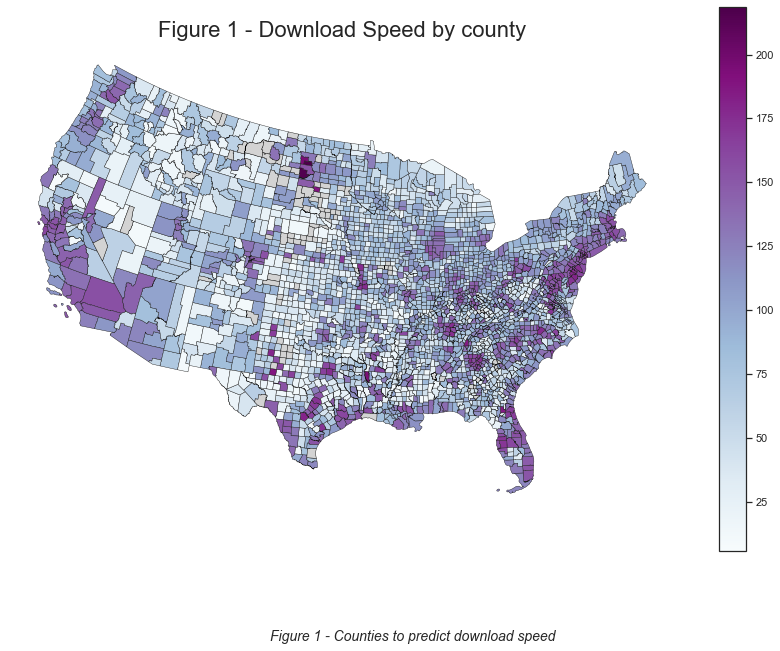

In [55]:
#['#8d95c6', '#88409b', '#4d024a']
#Plot the number of crimes on the map
sns.set(rc={'figure.figsize':(15, 10)})
sns.set_style("white")
fig,ax = plt.subplots()
county_data.plot(column='avg_d_mbps_wt', ax=ax, legend=True, cmap='BuPu', linewidth=0.4, edgecolor="0.1", 
               missing_kwds={"color": "lightgray","edgecolor": "black", "label": "Values to predict"})
# Set labels and titles.
plt.title('Figure 1 - Download Speed by county', fontsize=22)
txt= "Figure 1 - Counties to predict download speed"
plt.figtext(0.5, 0,s=txt, ha='center', fontsize=14, style='italic')
leg = ax.get_legend()

ax.axis("off")

(-2969748.062021963, 2331634.8865646683, 2537930.7192537906, 6269757.003164073)

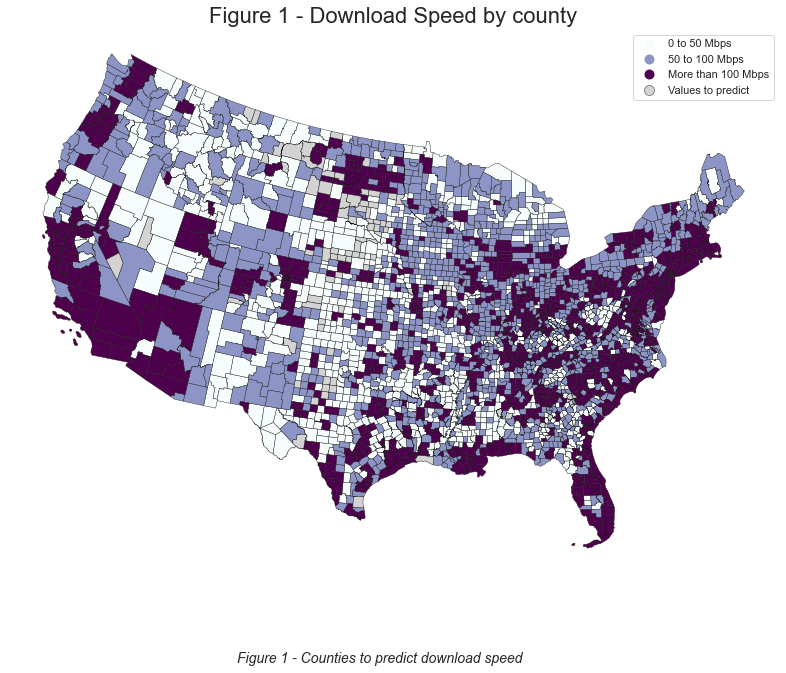

In [56]:
#['#8d95c6', '#88409b', '#4d024a']
county_data = county_data.sort_values(by='group_num')
#Plot the number of crimes on the map
sns.set(rc={'figure.figsize':(15, 10)})
sns.set_style("white")
fig,ax = plt.subplots()
county_data.plot(column='group_num', ax=ax, legend=True, categorical=True, cmap='BuPu', linewidth=0.4, edgecolor="0.1", 
               missing_kwds={"color": "lightgray","edgecolor": "black", "label": "Values to predict"})
# Set labels and titles.
plt.title('Figure 1 - Download Speed by county', fontsize=22)
txt= "Figure 1 - Counties to predict download speed"
plt.figtext(0.5, 0,s=txt, ha='center', fontsize=14, style='italic')
leg = ax.get_legend()
leg.get_texts()[0].set_text("0 to 50 Mbps")
leg.get_texts()[1].set_text("50 to 100 Mbps")
leg.get_texts()[2].set_text("More than 100 Mbps")
ax.axis("off")

In [11]:
county_data.head()

,GEOID,geometry,NAME,STATEFP,NAMELSAD,avg_d_mbps_wt,tests,group,group_num
0,31039,"POLYGON ((-330171.352 4699069.239, -330160.610...",Cuming,31,Cuming County,68.427149,871.0,50 to 100 Mbps,3
1,53069,"POLYGON ((-2288413.478 5806151.443, -2288581.2...",Wahkiakum,53,Wahkiakum County,24.719031,414.0,0 to 25 Mbps,1
2,35011,"POLYGON ((-1131778.997 3904448.706, -1131809.9...",De Baca,35,De Baca County,97.606335,170.0,50 to 100 Mbps,3
3,31109,"POLYGON ((-336816.696 4562417.023, -336747.675...",Lancaster,31,Lancaster County,168.666302,40265.0,More than 150 Mbps,5
4,31129,"POLYGON ((-462102.105 4499067.745, -462101.934...",Nuckolls,31,Nuckolls County,81.984861,238.0,50 to 100 Mbps,3


# Demographic Data

In [57]:
#Dataframe census data
import censusdata

# Useful for finding the ACS tables you want 
# censusdata.search('acs5', 2018, 'label', 'broadband') 
# censusdata.printtable(censusdata.censustable('acs5', 2018, 'B28011'))

# Pull ACS data 
census_tables = {
    'GEO_ID': 'GEO_ID', 
    'B02001_001E': 'Race Total', 
    'B02001_002E': 'White', 
    'B02001_003E': 'Black', 
    'B19013_001E': 'Median Income',
    'B01002_001E': 'Median Age',
    'B06009_001E': 'Education Total',
    'B06009_003E': 'High School graduate',
    'B25107_001E': 'Median Home Value', #Median Value by year built
    'B28003_002E': 'Households with computer',
    'B28001_005E': 'Households with smartphone'
    #'B25109_001E': 'Median Value by year moved',
    #'B25097_001E': 'Median Value by morgage',
    
    }

acs_df = censusdata.download("acs5", 
                              2018, 
                              censusdata.censusgeo([("state", "*"), 
                                                    ("county", "*"),]), list(census_tables.keys()))
acs_df["GEOID"] = acs_df["GEO_ID"].map(lambda x: str(x)[-5:])
acs_df = acs_df.drop(columns='GEO_ID')
acs_df = acs_df.rename(columns=census_tables)
acs_df.head()

,Race Total,White,Black,Median Income,Median Age,Education Total,High School graduate,Median Home Value,Households with computer,Households with smartphone,GEOID
"Washington County, Mississippi: Summary level: 050, state:28> county:151",47086,12097,33982,30834.0,36.9,30308.0,9254.0,74700,13858,11819,28151
"Perry County, Mississippi: Summary level: 050, state:28> county:111",12028,9475,2368,39007.0,40.9,8198.0,3290.0,83700,3552,3081,28111
"Choctaw County, Mississippi: Summary level: 050, state:28> county:019",8321,5631,2596,37203.0,44.0,5799.0,2201.0,81600,2345,1894,28019
"Itawamba County, Mississippi: Summary level: 050, state:28> county:057",23480,21346,1681,40510.0,40.0,15684.0,4743.0,89500,7103,6228,28057
"Carroll County, Mississippi: Summary level: 050, state:28> county:015",10129,6523,3503,43060.0,47.0,7248.0,2422.0,89300,2813,2413,28015


In [128]:
merged_gdf = (gpd.GeoDataFrame(county_data.merge(acs_df, on="GEOID", how="left"), crs=crs, geometry='geometry'))
merged_gdf['% White'] = merged_gdf['White'] / merged_gdf['Race Total'] * 100
merged_gdf['% Black'] = merged_gdf['Black'] / merged_gdf['Race Total'] * 100
merged_gdf['% High School'] = merged_gdf['High School graduate'] / merged_gdf['Education Total'] * 100
merged_gdf['% Computer'] = merged_gdf['Households with computer'] / merged_gdf['Race Total'] * 100
merged_gdf['% Smartphone'] = merged_gdf['Households with smartphone'] / merged_gdf['Race Total'] * 100
cols = ['GEOID', 'geometry', 'NAME', '% White', '% Black', 'Median Income', 'Median Age', 
        '% High School', 'Median Home Value', 'Households with computer', 'Households with smartphone', '% Computer', '% Smartphone', 'tests', 'group', 'group_num', 'avg_d_mbps_wt']
ml_data = merged_gdf[cols]
ml_data.head()

,GEOID,geometry,NAME,% White,% Black,Median Income,Median Age,% High School,Median Home Value,Households with computer,Households with smartphone,% Computer,% Smartphone,tests,group,group_num,avg_d_mbps_wt
0,19091,"POLYGON ((-109438.919 4758042.766, -109436.088...",Humboldt,97.376124,0.261342,52219.0,43.0,35.932356,102300,3481,2832,36.389295,29.604851,331.0,0 to 50 Mbps,1,45.418447
1,17017,"POLYGON ((220778.172 4438963.116, 220793.188 4...",Cass,89.869720,4.658508,51997.0,39.7,43.193687,78100,4261,3455,33.643901,27.279905,660.0,0 to 50 Mbps,1,21.006998
2,27155,"POLYGON ((-243290.779 5121765.621, -243272.573...",Traverse,92.238538,0.659275,48784.0,48.4,34.593023,82000,1341,1008,40.185796,30.206773,130.0,0 to 50 Mbps,1,42.578492
3,48255,"POLYGON ((-567961.359 3265539.841, -567771.711...",Karnes,72.613245,7.993761,52252.0,34.7,36.641221,97800,3052,2669,19.834926,17.345811,391.0,0 to 50 Mbps,1,14.056780
4,17171,"POLYGON ((187415.211 4400375.159, 187403.864 4...",Scott,98.196949,0.158510,53973.0,44.1,48.665355,85000,1675,1371,33.188032,27.164652,282.0,0 to 50 Mbps,1,22.596879


In [129]:
ml_data.groupby('group_num').size()

group_num
1     853
2    1143
3    1015
dtype: int64

In [130]:
ml_data.loc[ml_data['Median Home Value'] < 0, 'Median Home Value'] = ml_data['Median Home Value'].median()

test_data = ml_data[ml_data.avg_d_mbps_wt.isnull()]
train_data = ml_data[ml_data.avg_d_mbps_wt.notnull()]

median_income = train_data['Median Income'].median()
train_data.loc[:, 'Median Income'] = train_data['Median Income'].fillna(value=median_income)

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [131]:
train_data.head()

,GEOID,geometry,NAME,% White,% Black,Median Income,Median Age,% High School,Median Home Value,Households with computer,Households with smartphone,% Computer,% Smartphone,tests,group,group_num,avg_d_mbps_wt
0,19091,"POLYGON ((-109438.919 4758042.766, -109436.088...",Humboldt,97.376124,0.261342,52219.0,43.0,35.932356,102300.0,3481,2832,36.389295,29.604851,331.0,0 to 50 Mbps,1,45.418447
1,17017,"POLYGON ((220778.172 4438963.116, 220793.188 4...",Cass,89.869720,4.658508,51997.0,39.7,43.193687,78100.0,4261,3455,33.643901,27.279905,660.0,0 to 50 Mbps,1,21.006998
2,27155,"POLYGON ((-243290.779 5121765.621, -243272.573...",Traverse,92.238538,0.659275,48784.0,48.4,34.593023,82000.0,1341,1008,40.185796,30.206773,130.0,0 to 50 Mbps,1,42.578492
3,48255,"POLYGON ((-567961.359 3265539.841, -567771.711...",Karnes,72.613245,7.993761,52252.0,34.7,36.641221,97800.0,3052,2669,19.834926,17.345811,391.0,0 to 50 Mbps,1,14.056780
4,17171,"POLYGON ((187415.211 4400375.159, 187403.864 4...",Scott,98.196949,0.158510,53973.0,44.1,48.665355,85000.0,1675,1371,33.188032,27.164652,282.0,0 to 50 Mbps,1,22.596879


# Models

In [192]:
features = ['% White', '% Black','Median Income', 'Median Age', '% High School', 'Median Home Value', 'Households with computer', 'Households with smartphone']
label = ['group_num']

x_train = train_data.loc[:,features]
y_train = train_data.loc[:,label].round()
x_test = test_data.loc[:,features]
y_test = test_data.loc[:,label].round()
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

In [193]:
# creating a KFold object with 5 splits 
folds = KFold(n_splits = 10, shuffle = True, random_state = 100)

# specify range of hyperparameters
hyper_params = [{'n_features_to_select': list(range(2, 9))}]

#Custom Function for accuracy
def custom_acc(y_train, y_pred):
    y_pred = np.where(y_pred < 1, 1, np.where(y_pred > 3, 3, y_pred.round()))
    #y_pred = y_pred.round()
    diff = (y_pred == y_train).sum()
    return diff/len(y_train)

acc = make_scorer(custom_acc)

In [207]:
train_data.group_num.unique()

[1, 2, 3]
Categories (3, int64): [1 < 2 < 3]

### Linear Regression

In [194]:
# Lineal Model
lm = LinearRegression(normalize=True)
lm.fit(x_train, y_train)
rfe = RFE(lm)  

# set up GridSearchCV()
model_cv = GridSearchCV(estimator = rfe, 
                        param_grid = hyper_params, 
                        scoring= acc, 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)      

# fit the model
results = model_cv.fit(x_train, y_train)
ls_results = pd.DataFrame(results.cv_results_)

Fitting 10 folds for each of 7 candidates, totalling 70 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:    0.5s finished


In [195]:
ls_results.filter(['param_n_features_to_select','mean_test_score', 'rank_test_score', 'mean_train_score'])


,param_n_features_to_select,mean_test_score,rank_test_score,mean_train_score
0,2,0.426098,5,0.425698
1,3,0.425103,6,0.427285
2,4,0.421448,7,0.421307
3,5,0.447356,4,0.445625
4,6,0.456325,3,0.455183
5,7,0.488542,1,0.491383
6,8,0.486547,2,0.489022


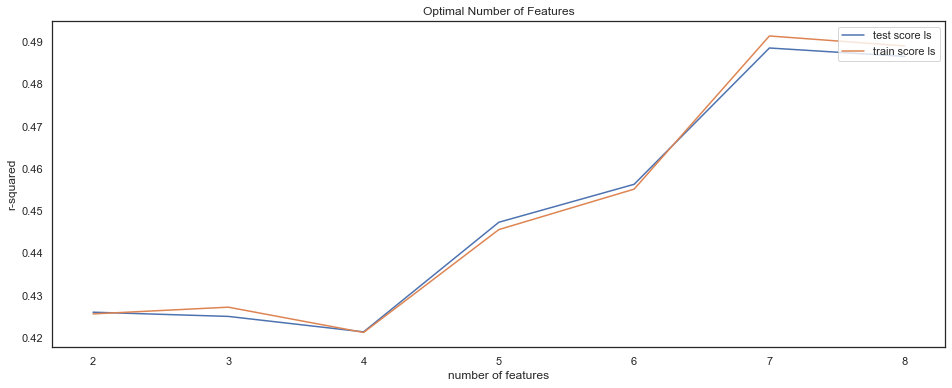

In [196]:
plt.figure(figsize=(16,6))
plt.plot(ls_results["param_n_features_to_select"], ls_results["mean_test_score"])
plt.plot(ls_results["param_n_features_to_select"], ls_results["mean_train_score"])
plt.xlabel('number of features')
#plt.ylim(0,1)
plt.ylabel('r-squared')
plt.title("Optimal Number of Features")
plt.legend(['test score ls', 'train score ls'], loc='upper right')

In [197]:
lm = LinearRegression(normalize=True)
folds = KFold(n_splits = 10, shuffle = True, random_state = 100)
res = cross_val_score(lm, x_train, y_train, cv=folds, scoring=acc)
print(res.mean())

0.48654705066995224


In [208]:
reg = LinearRegression().fit(x_train, y_train)
y_pred_ls = reg.predict(x_test)
y_pred_ls = np.where(y_pred_ls < 1, 1, np.where(y_pred_ls > 3, 3, y_pred_ls.round()))
y_pred_ls_t = reg.predict(x_train)
y_pred_ls_t = np.where(y_pred_ls_t  < 1, 1, np.where(y_pred_ls_t  > 3, 3, y_pred_ls_t.round()))

w = reg.coef_
importance = abs(w).argsort()[::-1]
for i in importance:
    print(list(x_test.columns)[importance[i]])

% High School
% Black
Median Age
Households with smartphone
Median Home Value
Median Income
% White
Households with computer


In [209]:
train_data['pred'] = y_pred_ls_t
test_data['pred'] = y_pred_ls
map_data = train_data.append(test_data)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


/opt/anaconda3/lib/python3.7/site-packages/geopandas/plotting.py:335: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,


(-2969748.062021963, 2331634.8865646683, 2537930.7192537906, 6269757.003164073)

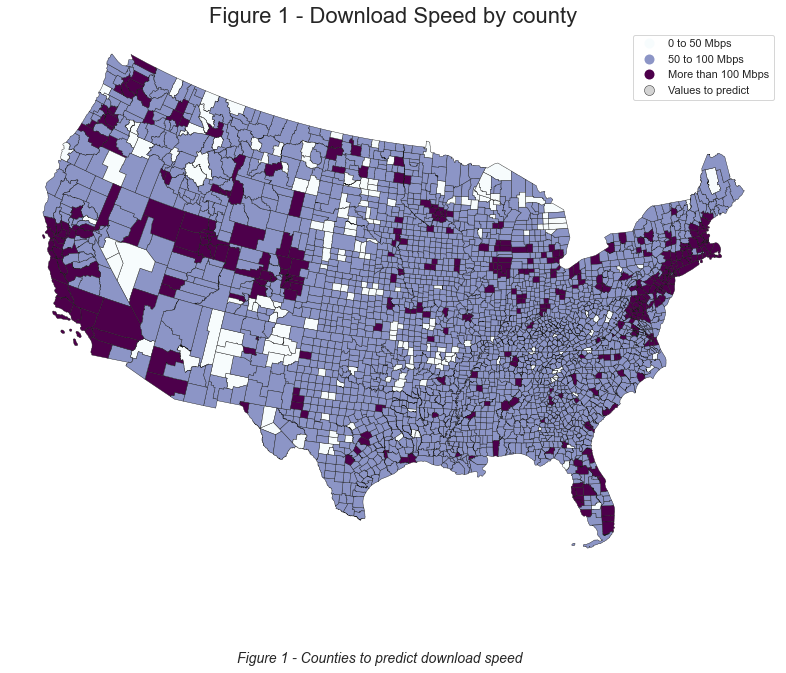

In [211]:
#['#8d95c6', '#88409b', '#4d024a']
county_data = county_data.sort_values(by='group_num')
#Plot the number of crimes on the map
sns.set(rc={'figure.figsize':(15, 10)})
sns.set_style("white")
fig,ax = plt.subplots()
map_data.plot(column='pred', ax=ax, legend=True, categorical=True, cmap='BuPu', linewidth=0.4, edgecolor="0.1", 
               missing_kwds={"color": "lightgray","edgecolor": "black", "label": "Values to predict"})

# Set labels and titles.
plt.title('Figure 1 - Download Speed by county', fontsize=22)
txt= "Figure 1 - Counties to predict download speed"
plt.figtext(0.5, 0,s=txt, ha='center', fontsize=14, style='italic')
leg = ax.get_legend()
leg.get_texts()[0].set_text("0 to 50 Mbps")
leg.get_texts()[1].set_text("50 to 100 Mbps")
leg.get_texts()[2].set_text("More than 100 Mbps")
ax.axis("off")

## Ridge Regression

In [212]:
#---------RIDGE----------------

# specify range of hyperparameters
alpha = [10**1, 10**5, 10**10]

df_rd = pd.DataFrame(columns = ['alpha', 'features','mean_test_score', 'rank_test_score', 'mean_train_score']) 

for i in alpha:
    # specify model
    rd = Ridge(alpha=i, normalize=False)
    rd.fit(x_train, y_train)
    rfe_rd = RFE(rd)  

    # set up GridSearchCV()
    model_rd = GridSearchCV(estimator = rfe_rd, 
                            param_grid = hyper_params, 
                            scoring= acc, 
                            cv = folds, 
                            verbose = 1,
                            return_train_score=True)      

    # fit the model
    results_rd = model_rd.fit(x_train, y_train)
    rd_results = pd.DataFrame(results_rd.cv_results_)
    for index, row in rd_results.iterrows():
        df_rd = df_rd.append({'alpha' : i, 'features' : rd_results.loc[index, 'param_n_features_to_select'], 
                              'mean_test_score' : rd_results.loc[index, 'mean_test_score'], 
                              'rank_test_score':rd_results.loc[index, 'rank_test_score'],
                             'mean_train_score':rd_results.loc[index, 'mean_train_score']},  
                    ignore_index = True)

df_rd

Fitting 10 folds for each of 7 candidates, totalling 70 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 10 folds for each of 7 candidates, totalling 70 fits


[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 10 folds for each of 7 candidates, totalling 70 fits


[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:    0.4s finished


,alpha,features,mean_test_score,rank_test_score,mean_train_score
0,1.000000e+01,2.0,0.426098,5.0,0.425661
1,1.000000e+01,3.0,0.424771,6.0,0.427211
2,1.000000e+01,4.0,0.421448,7.0,0.421307
3,1.000000e+01,5.0,0.447356,4.0,0.445588
4,1.000000e+01,6.0,0.456325,3.0,0.455183
5,1.000000e+01,7.0,0.488542,1.0,0.491346
6,1.000000e+01,8.0,0.486547,2.0,0.489022
7,1.000000e+05,2.0,0.382270,7.0,0.382634
8,1.000000e+05,3.0,0.383598,6.0,0.384627
9,1.000000e+05,4.0,0.389578,5.0,0.388206


In [213]:
### CV Result!!
rd = Ridge(alpha=(10**1), normalize=False)
folds = KFold(n_splits = 10, shuffle = True, random_state = 100)
res = cross_val_score(rd, x_train, y_train, cv=folds, scoring=acc)
print(res.mean())

0.48654705066995224


In [214]:
rd = Ridge(alpha=(10**1), normalize=False)
rd.fit(x_train, y_train)

# predict prices of X_test
y_pred_rd = rd.predict(x_test)
y_pred_rd = np.where(y_pred_rd  < 1, 1, np.where(y_pred_rd  > 3, 3, y_pred_rd.round()))
y_pred_rd_t = rd.predict(x_train)
y_pred_rd_t = np.where(y_pred_rd_t < 1, 1, np.where(y_pred_rd_t > 3, 3, y_pred_rd_t.round()))


w = rd.coef_
w

array([ 1.05520854e-02,  1.39127132e-02,  1.10786183e-05, -4.40383881e-02,
       -3.51740786e-03,  1.20091491e-06,  6.45783294e-05, -7.21132790e-05])

In [216]:
importance = abs(w).argsort()[::-1]
importance

array([3, 1, 0, 4, 7, 6, 2, 5])

In [217]:
for i in importance:
    print(list(x_test.columns)[importance[i]])

% High School
% Black
Median Age
Households with smartphone
Median Home Value
Median Income
% White
Households with computer


In [218]:
train_data['pred'] = y_pred_rd_t
test_data['pred'] = y_pred_rd
map_data = train_data.append(test_data)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


/opt/anaconda3/lib/python3.7/site-packages/geopandas/plotting.py:335: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,


(-2969748.062021963, 2331634.8865646683, 2537930.7192537906, 6269757.003164073)

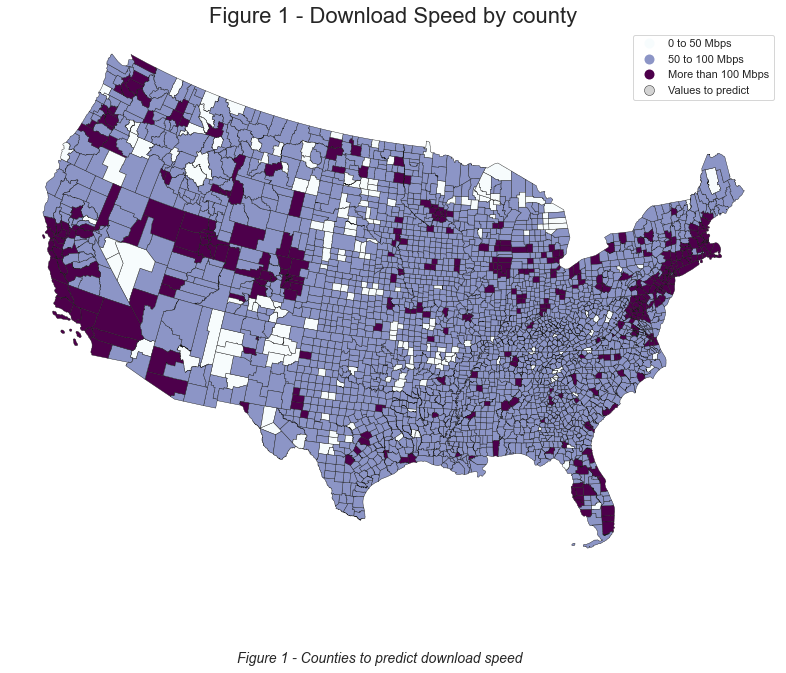

In [219]:
#['#8d95c6', '#88409b', '#4d024a']
#Plot the number of crimes on the map
sns.set(rc={'figure.figsize':(15, 10)})
sns.set_style("white")
fig,ax = plt.subplots()
map_data.plot(column='pred', ax=ax, legend=True, categorical=True, cmap='BuPu', linewidth=0.4, edgecolor="0.1", 
               missing_kwds={"color": "lightgray","edgecolor": "black", "label": "Values to predict"})

# Set labels and titles.
plt.title('Figure 1 - Download Speed by county', fontsize=22)
txt= "Figure 1 - Counties to predict download speed"
plt.figtext(0.5, 0,s=txt, ha='center', fontsize=14, style='italic')
leg = ax.get_legend()
leg.get_texts()[0].set_text("0 to 50 Mbps")
leg.get_texts()[1].set_text("50 to 100 Mbps")
leg.get_texts()[2].set_text("More than 100 Mbps")
ax.axis("off")

### Logistic Regression

In [ ]:
#--------------------Logistic Regression-----------------------------
from sklearn.linear_model import LogisticRegression
# specify range of hyperparameters
C = [0.01, 0.1,1,10,100]

df_clf = pd.DataFrame(columns = ['C', 'features','mean_test_score', 'rank_test_score', 'mean_train_score']) 

# specify model
for i in C:
    clf = LogisticRegression(random_state=0, max_iter=1000, solver='lbfgs', C=i, class_weight='balanced', multi_class='multinomial')
    clf.fit(x_train, y_train)
    rfe_clf = RFE(clf)  

    # set up GridSearchCV()
    model_clf = GridSearchCV(estimator = rfe_clf, 
                            param_grid = hyper_params, 
                            scoring= acc, 
                            cv = folds, 
                            verbose = 1,
                            return_train_score=True)      

    # fit the model
    results_clf = model_clf.fit(x_train, y_train)
    clf_results = pd.DataFrame(results_clf.cv_results_)
    for index, row in clf_results.iterrows():
        df_clf = df_clf.append({'C' : i, 'features' : clf_results.loc[index, 'param_n_features_to_select'], 
                              'mean_test_score' : clf_results.loc[index, 'mean_test_score'], 
                              'rank_test_score':clf_results.loc[index, 'rank_test_score'],
                             'mean_train_score':clf_results.loc[index, 'mean_train_score']},  
                    ignore_index = True)

df_clf

In [221]:
# final model Logistic
n_features_optimal = 8

clf = LogisticRegression(random_state=0, max_iter=1000, solver='lbfgs', C=0.10, class_weight='balanced', multi_class='multinomial')
clf.fit(x_train, y_train)
rfe_clf = RFE(clf, n_features_to_select=n_features_optimal)
          
model_clf = GridSearchCV(estimator = rfe_clf, 
                param_grid = hyper_params, 
                scoring= acc, 
                cv = folds, 
                verbose = 1,
                return_train_score=True)     
results_clf = model_clf.fit(x_train, y_train)
clf_results = pd.DataFrame(results_clf.cv_results_)

# predict prices of X_test
y_pred_clf = (results_clf.predict(x_test)).round()
y_pred_clf_r = (results_clf.predict(x_train)).round()

Fitting 10 folds for each of 7 candidates, totalling 70 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:   40.4s finished


In [222]:
clf_results.filter(['param_n_features_to_select','mean_test_score', 'rank_test_score', 'mean_train_score'])

,param_n_features_to_select,mean_test_score,rank_test_score,mean_train_score
0,2,0.461633,7,0.463301
1,3,0.500497,6,0.503118
2,4,0.504814,5,0.506144
3,5,0.610087,4,0.611609
4,6,0.615070,3,0.615189
5,7,0.620050,2,0.621794
6,8,0.621048,1,0.623049


In [ ]:
### CV Result!!
clf = LogisticRegression(random_state=0, max_iter=1000, solver='lbfgs', C=0.10, class_weight='balanced', multi_class='multinomial')
folds = KFold(n_splits = 10, shuffle = True, random_state = 100)
res = cross_val_score(clf, x_train, y_train, cv=folds, scoring=acc)
print(res.mean())

In [238]:
clf = LogisticRegression(random_state=0, max_iter=1000, solver='lbfgs', C=0.10, class_weight='balanced', multi_class='multinomial')
clf.fit(x_train, y_train)

y_pred_clf = clf.predict(x_test).round()
y_pred_clf_r = clf.predict(x_train).round()

w = clf.coef_
w

array([[ 9.02767691e-03,  9.11446659e-03, -6.94185125e-06,
         1.12973575e-02,  8.75449930e-03, -8.54969845e-09,
         6.90960985e-05, -2.72677831e-04],
       [ 4.04871912e-03, -7.07516249e-03, -4.91014228e-06,
        -2.54518001e-03, -2.21770183e-03, -2.49672656e-07,
         4.90074888e-05,  1.70577177e-05],
       [-1.30763960e-02, -2.03930410e-03,  1.18519935e-05,
        -8.75217747e-03, -6.53679747e-03,  2.58222318e-07,
        -1.18103588e-04,  2.55620113e-04]])

In [239]:
y_pred_clf

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1])

In [240]:
importance = abs(w[2]).argsort()[::-1]
importance

array([0, 3, 4, 1, 7, 6, 2, 5])

In [241]:
for i in importance:
    print(list(x_test.columns)[importance[i]])

% White
% Black
Households with smartphone
Median Age
Median Home Value
Median Income
% High School
Households with computer


In [242]:
train_data['pred'] = y_pred_clf_r
test_data['pred'] = y_pred_clf
map_data = train_data.append(test_data) 

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


(-2969748.062021963, 2331634.8865646683, 2537930.7192537906, 6269757.003164073)

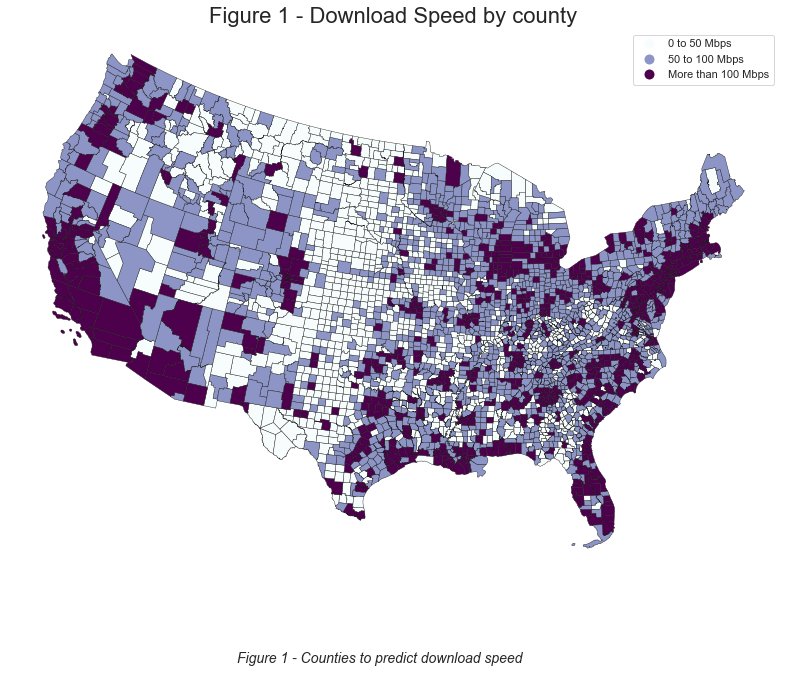

In [249]:
#['#8d95c6', '#88409b', '#4d024a']
county_data = county_data.sort_values(by='group_num')
#Plot the number of crimes on the map
sns.set(rc={'figure.figsize':(15, 10)})
sns.set_style("white")
fig,ax = plt.subplots()
map_data.plot(column='pred', ax=ax, legend=True, categorical=True, cmap='BuPu', linewidth=0.4, edgecolor="0.1", 
              )

# Set labels and titles.
plt.title('Figure 1 - Download Speed by county', fontsize=22)
txt= "Figure 1 - Counties to predict download speed"
plt.figtext(0.5, 0,s=txt, ha='center', fontsize=14, style='italic')
leg = ax.get_legend()
leg.get_texts()[0].set_text("0 to 50 Mbps")
leg.get_texts()[1].set_text("50 to 100 Mbps")
leg.get_texts()[2].set_text("More than 100 Mbps")
ax.axis("off")

(-2969748.062021963, 2331634.8865646683, 2537930.7192537906, 6269757.003164073)

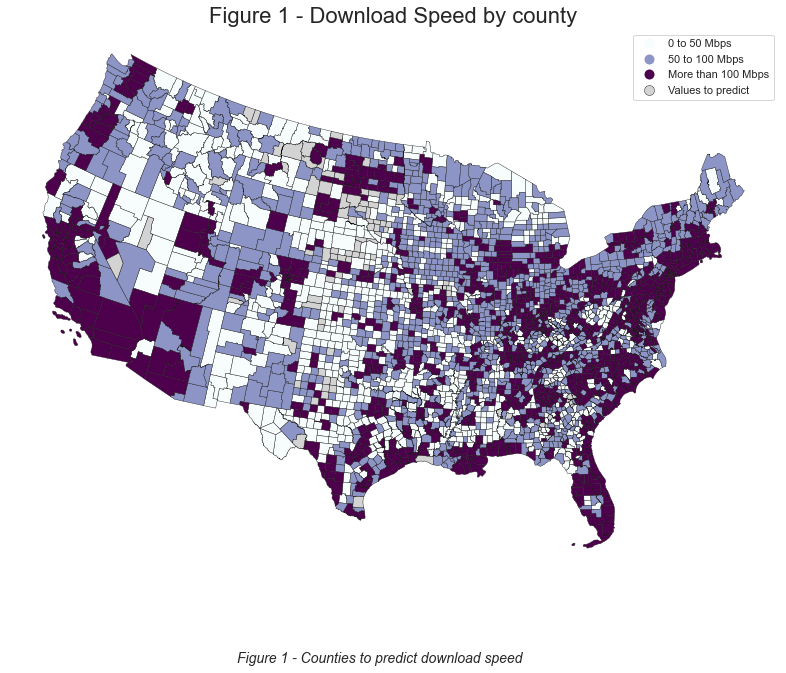

In [166]:
#Plot the number of crimes on the map
sns.set(rc={'figure.figsize':(15, 10)})
sns.set_style("white")
fig,ax = plt.subplots()
county_data.plot(column='group_num', ax=ax, legend=True, categorical=True, cmap='BuPu', linewidth=0.4, edgecolor="0.1", 
               missing_kwds={"color": "lightgray","edgecolor": "black", "label": "Values to predict"})
# Set labels and titles.
plt.title('Figure 1 - Download Speed by county', fontsize=22)
txt= "Figure 1 - Counties to predict download speed"
plt.figtext(0.5, 0,s=txt, ha='center', fontsize=14, style='italic')
leg = ax.get_legend()
leg.get_texts()[0].set_text("0 to 50 Mbps")
leg.get_texts()[1].set_text("50 to 100 Mbps")
leg.get_texts()[2].set_text("More than 100 Mbps")
ax.axis("off")

In [ ]:
#--------------------SVM-----------------------------
folds = KFold(n_splits = 5, shuffle = True, random_state = 100)


# specify range of hyperparameters
C = [1]

df_svm = pd.DataFrame(columns = ['C', 'features','mean_test_score', 'rank_test_score', 'mean_train_score']) 

for i in C:
    # specify model
    svm = SVC(kernel='linear', C=i)
    svm.fit(x_train, y_train)
    rfe_svm = RFE(svm)  

    # set up GridSearchCV()
    model_svm = GridSearchCV(estimator = rfe_svm, 
                            param_grid = hyper_params, 
                            scoring= acc, 
                            cv = folds, 
                            verbose = 1,
                            return_train_score=True)      

    # fit the model
    results_svm = model_svm.fit(x_train, y_train)
    svm_results = pd.DataFrame(results_svm.cv_results_)
    for index, row in svm_results.iterrows():
        df_svm = df_svm.append({'C' : i, 'features' : svm_results.loc[index, 'param_n_features_to_select'], 
                              'mean_test_score' : svm_results.loc[index, 'mean_test_score'], 
                              'rank_test_score':svm_results.loc[index, 'rank_test_score'],
                             'mean_train_score':svm_results.loc[index, 'mean_train_score']},  
                    ignore_index = True)

df_svm

In [244]:
svm = SVC(kernel='linear', C=1)
folds = KFold(n_splits = 5, shuffle = True, random_state = 100)
res = cross_val_score(svm, x_train, y_train, cv=folds, scoring=acc)
print(res.mean())

0.6316744075855496


In [245]:
clf = SVC(kernel='linear', C=1)
clf.fit(x_train, y_train)

y_pred_clf = clf.predict(x_test).round()
y_pred_clf_r = clf.predict(x_train).round()

In [248]:
y_pred_clf

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1])

In [246]:
train_data['pred'] = y_pred_clf_r
test_data['pred'] = y_pred_clf
map_data = train_data.append(test_data)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


(-2969748.062021963, 2331634.8865646683, 2537930.7192537906, 6269757.003164073)

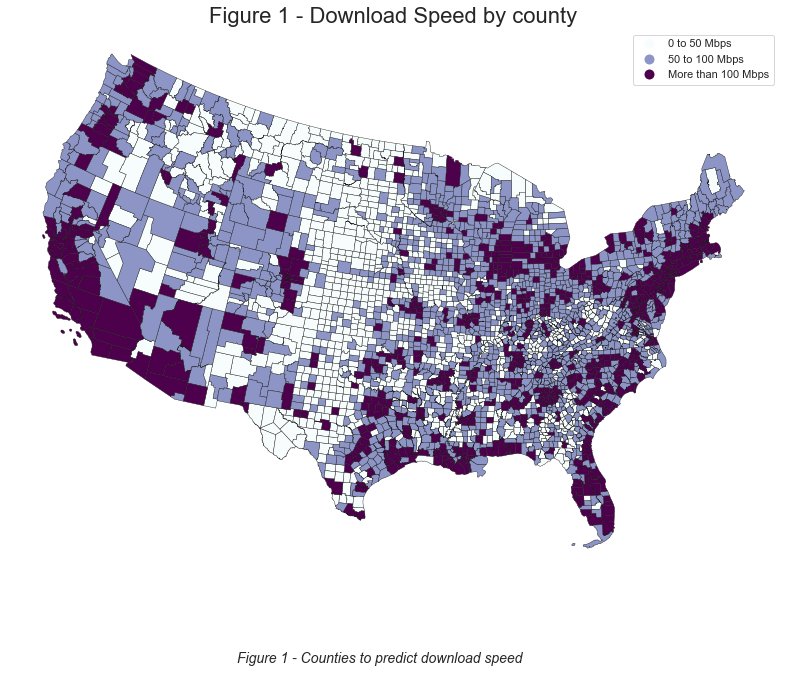

In [247]:
sns.set(rc={'figure.figsize':(15, 10)})
sns.set_style("white")
fig,ax = plt.subplots()
map_data.plot(column='pred', ax=ax, legend=True, categorical=True, cmap='BuPu', linewidth=0.4, edgecolor="0.1", 
              )

# Set labels and titles.
plt.title('Figure 1 - Download Speed by county', fontsize=22)
txt= "Figure 1 - Counties to predict download speed"
plt.figtext(0.5, 0,s=txt, ha='center', fontsize=14, style='italic')
leg = ax.get_legend()
leg.get_texts()[0].set_text("0 to 50 Mbps")
leg.get_texts()[1].set_text("50 to 100 Mbps")
leg.get_texts()[2].set_text("More than 100 Mbps")
ax.axis("off")